# 1 CNN for image classification

In [1]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
!wget https://archive.ics.uci.edu/static/public/908/realwaste.zip

--2024-12-12 12:46:14--  https://archive.ics.uci.edu/static/public/908/realwaste.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘realwaste.zip’

realwaste.zip           [   <=>              ] 656.65M  65.4MB/s    in 14s     

2024-12-12 12:46:28 (46.5 MB/s) - ‘realwaste.zip’ saved [688545323]



In [15]:
!unzip realwaste.zip

Archive:  realwaste.zip
797f4fca27a3a85e4c27131cdb7d9a9a5d72c494
   creating: realwaste-main/
  inflating: realwaste-main/README.md  
   creating: realwaste-main/RealWaste/
   creating: realwaste-main/RealWaste/Cardboard/
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_1.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_10.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_100.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_101.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_102.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_103.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_104.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_105.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_106.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_107.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_108.jpg  
  inflating: realwaste-main/RealW

In [16]:
from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader

In [17]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [18]:
import os
num_workers = os.cpu_count()
print(f"Number of CPU cores: {num_workers}")

Number of CPU cores: 2


In [19]:
# use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [20]:
# Get the mean and variance of the dataset

# Minimal transform to load images as tensors
transform = transforms.Compose([
    transforms.ToTensor()  # Convert to tensor
])

dataset = datasets.ImageFolder(root="realwaste-main/RealWaste", transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=num_workers)

In [21]:
import torch

mean = 0.0
std = 0.0
total_images = 0

for images, _ in loader:
    batch_samples = images.size(0)  # Batch size (number of images in this batch)
    images = images.view(batch_samples, images.size(1), -1)  # Flatten height and width
    mean += images.mean(2).sum(0)  # Sum the mean of each channel
    std += images.std(2).sum(0)    # Sum the std of each channel
    total_images += batch_samples

mean /= total_images
std /= total_images

print(f"Mean: {mean}")
print(f"Standard Deviation: {std}")

Mean: tensor([0.5979, 0.6191, 0.6317])
Standard Deviation: tensor([0.1551, 0.1636, 0.1820])


In [24]:
from torch.utils.data import DataLoader, random_split # Add random_split to the import statement

transform = transforms.Compose([
    transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
])

data_dir = '/content/realwaste-main/RealWaste'

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_size = int(0.6 * len(dataset))  # 80% train, 20% validation
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# new transformation

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
image_datasets = {'train': train_dataset, 'val': val_dataset, 'test': test_dataset}

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of validation examples: {len(val_dataset)}")
print(f"Number of testing examples: {len(test_dataset)}")

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].dataset.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Number of training examples: 2851
Number of validation examples: 950
Number of testing examples: 951


In [25]:
print(f"{mean=}")
print(f"{std=}")

mean=tensor([0.5979, 0.6191, 0.6317])
std=tensor([0.1551, 0.1636, 0.1820])


## Visualise dataset

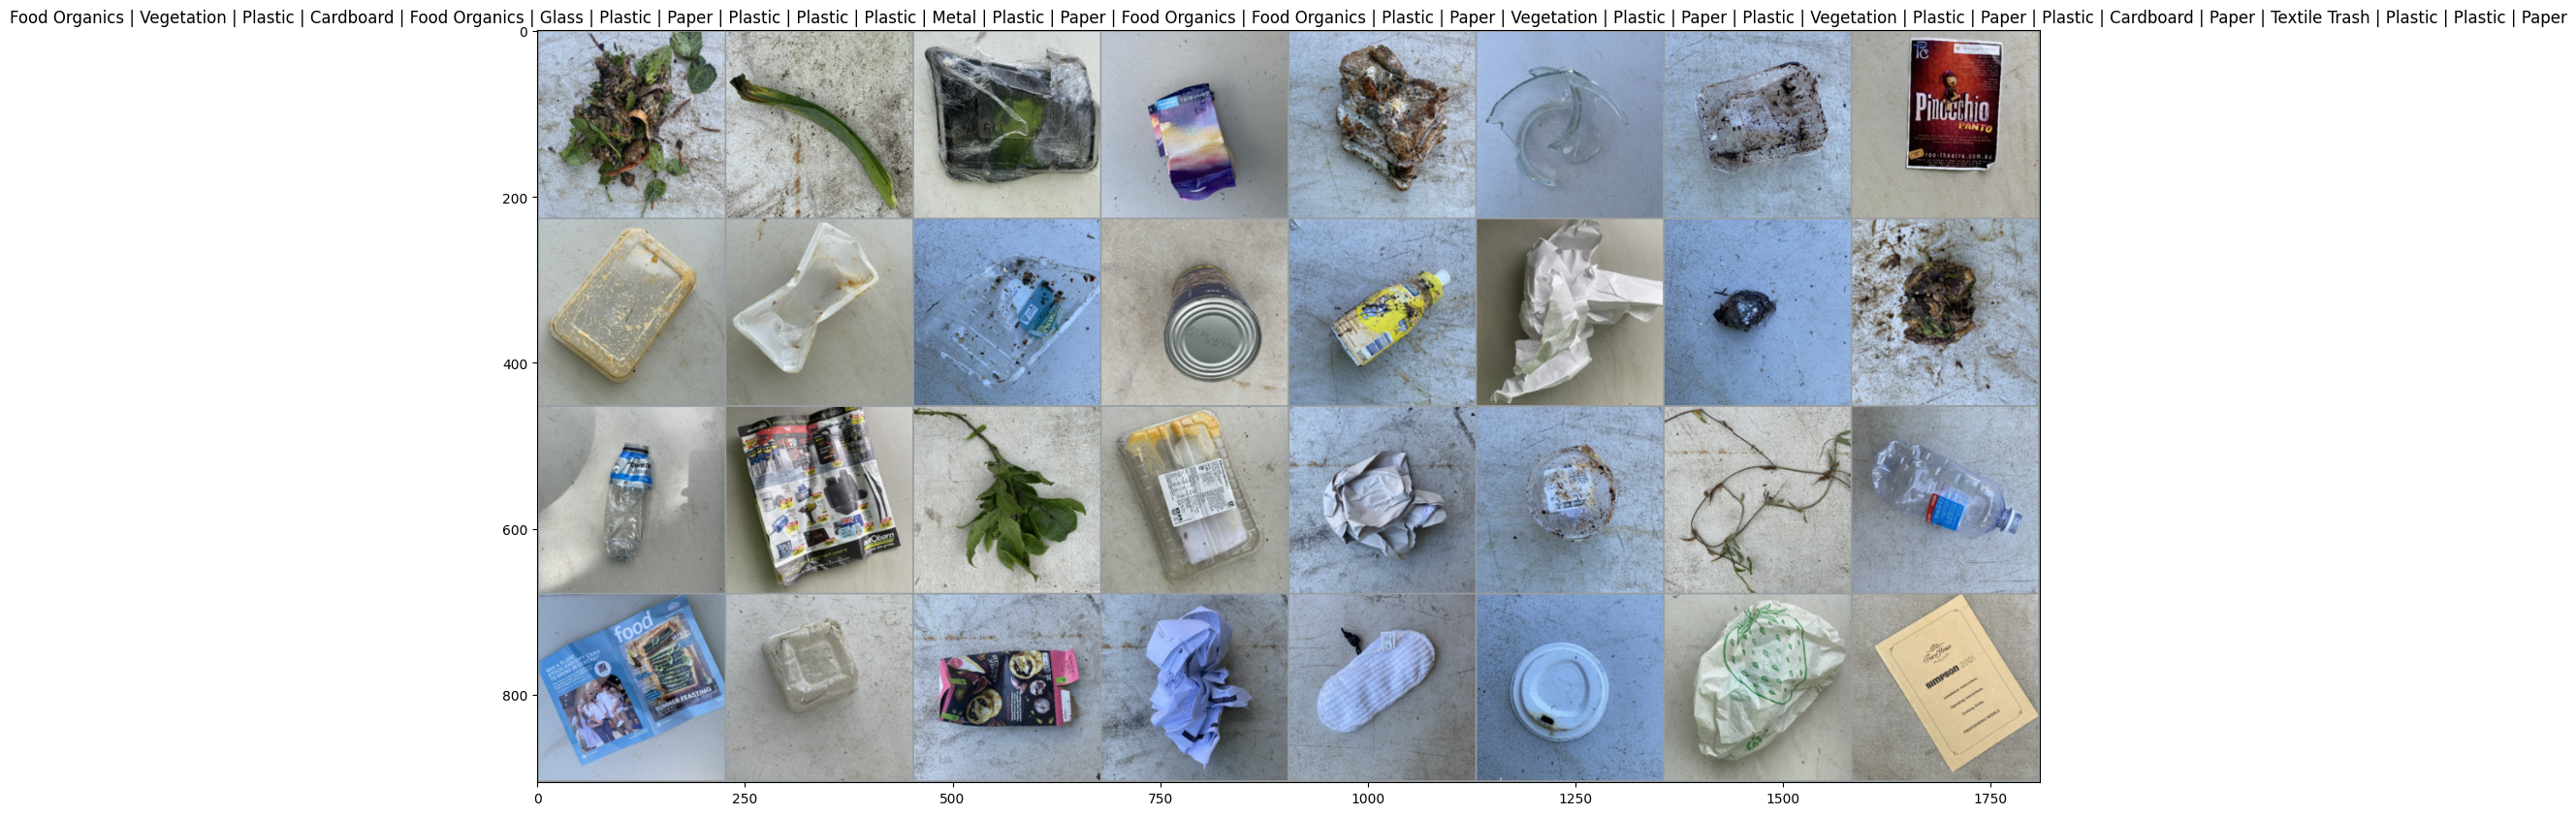

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

def imshow(inp, title=None, figsize=(15, 15)):
    """Display image for Tensor with a larger figure size."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5979, 0.6191, 0.6317])
    std = np.array([0.1551, 0.1636, 0.1820])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    # Create a larger figure
    plt.figure(figsize=figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from the batch
out = torchvision.utils.make_grid(inputs)

# Adjust the class names mapping as needed
class_names = image_datasets['train'].dataset.classes  # Use classes from the ImageFolder

# Display the image with a larger plot
imshow(out, title=" | ".join([class_names[x] for x in classes]), figsize=(20, 20))


In [27]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 224, 224])

In [28]:
dataset.classes

['Cardboard',
 'Food Organics',
 'Glass',
 'Metal',
 'Miscellaneous Trash',
 'Paper',
 'Plastic',
 'Textile Trash',
 'Vegetation']

In [29]:
dataset.class_to_idx

{'Cardboard': 0,
 'Food Organics': 1,
 'Glass': 2,
 'Metal': 3,
 'Miscellaneous Trash': 4,
 'Paper': 5,
 'Plastic': 6,
 'Textile Trash': 7,
 'Vegetation': 8}

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

d = dropout_rate = 0.5
K = len(dataset.classes)

class TrashClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),

            # Flatten the output
            nn.Flatten()
        )

        # Add a method to calculate the flattened features
        self.calculate_flattened_features = self._get_flattened_features()

        self.classifier = nn.Sequential(
            nn.Linear(in_features=self.calculate_flattened_features, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate, inplace=False),
            nn.Linear(in_features=512, out_features=K),
            nn.Softmax(dim=1)
        )

    def _get_flattened_features(self):
        # Use a dummy input to calculate the number of flattened features
        test_input = torch.randn(1, 3, 224, 224)  # Assuming input image size is 224x224
        with torch.no_grad():
            x = self.encoder(test_input)
            return x.shape[1]

    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

    def test_archtecture(self, x):
        print("")
        for layer in self.encoder:
            x = layer(x)
            print(f"Layer: {layer.__class__.__name__}, Output shape: {x.shape}")

        print("Classifier :")
        for layer in self.classifier:
            x = layer(x)
            print(f"Layer: {layer.__class__.__name__}, Output shape: {x.shape}")

In [31]:
next(iter(train_loader))[0].shape

torch.Size([32, 3, 224, 224])

In [32]:
torch.device

torch.device

In [33]:
random_test_tensor = torch.randn(3, 224, 224).unsqueeze(0)

In [34]:
random_test_tensor.shape

torch.Size([1, 3, 224, 224])

In [35]:
trash_classifier = TrashClassifier()
trash_classifier.test_archtecture(random_test_tensor)


Layer: Conv2d, Output shape: torch.Size([1, 64, 224, 224])
Layer: ReLU, Output shape: torch.Size([1, 64, 224, 224])
Layer: MaxPool2d, Output shape: torch.Size([1, 64, 112, 112])
Layer: Conv2d, Output shape: torch.Size([1, 128, 112, 112])
Layer: ReLU, Output shape: torch.Size([1, 128, 112, 112])
Layer: MaxPool2d, Output shape: torch.Size([1, 128, 56, 56])
Layer: Conv2d, Output shape: torch.Size([1, 256, 56, 56])
Layer: ReLU, Output shape: torch.Size([1, 256, 56, 56])
Layer: MaxPool2d, Output shape: torch.Size([1, 256, 28, 28])
Layer: Conv2d, Output shape: torch.Size([1, 512, 28, 28])
Layer: ReLU, Output shape: torch.Size([1, 512, 28, 28])
Layer: MaxPool2d, Output shape: torch.Size([1, 512, 28, 28])
Layer: Flatten, Output shape: torch.Size([1, 401408])
Classifier :
Layer: Linear, Output shape: torch.Size([1, 512])
Layer: ReLU, Output shape: torch.Size([1, 512])
Layer: Dropout, Output shape: torch.Size([1, 512])
Layer: Linear, Output shape: torch.Size([1, 9])
Layer: Softmax, Output shape

In [36]:
import time

def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        # Lists to store metrics for plotting
        train_losses, val_losses = [], []
        train_accuracies, val_accuracies = [], []

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'train':
                    train_losses.append(epoch_loss)
                    train_accuracies.append(epoch_acc.item())
                    scheduler.step()
                else:
                    val_losses.append(epoch_loss)
                    val_accuracies.append(epoch_acc.item())

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    losses = {'train': train_losses, 'val': val_losses}
    accuracies = {'train': train_accuracies, 'val': val_accuracies}

    return model, losses, accuracies

In [37]:
break

SyntaxError: 'break' outside loop (<ipython-input-37-6aaf1f276005>, line 1)

In [ ]:
lr_array = [0.0001, 0.001, 0.01, 0.1]

In [ ]:
losses_dict = {
          "0.0001":None,
          "0.001":None,
          "0.01":None,
          "0.1":None
}

accuracies_dict = {
          "0.0001":None,
          "0.001":None,
          "0.01":None,
          "0.1":None
}

models_dict = {
    "0.0001":None,
    "0.001":None,
    "0.01":None,
    "0.1":None
}

In [ ]:
for lr in lr_array:
    print(f"Training with learning rate: {lr}")
    trash_classifier_from_scratch = TrashClassifier()

    trash_classifier_from_scratch.to(device)

    optimizer = optim.Adam(trash_classifier_from_scratch.parameters(), lr=lr)

    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    finetuned_model, losses, accuracies = train_model(
        model=trash_classifier_from_scratch,
        criterion=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler = exp_lr_scheduler,
        num_epochs=20
    )

    # Save models for each learning rate
    torch.save(trash_classifier_from_scratch.state_dict(), f"trash_classifier_from_scratch_{lr}.pth")

    losses_dict[str(lr)] = losses
    accuracies_dict[str(lr)] = accuracies
    models_dict[str(lr)] = trash_classifier_from_scratch.state_dict()

### Evaluate model

In [ ]:
import pickle

# Replace with the actual paths to your pickle files
losses_file_path = '/content/drive/MyDrive/pr_group_assignment/losses_dict.pkl'
accuracies_file_path = '/content/drive/MyDrive/pr_group_assignment/accuracies_dict.pkl'

# Load the pickle files as dictionaries
with open(losses_file_path, 'rb') as losses_file:
    losses_dict = pickle.load(losses_file)

with open(accuracies_file_path, 'rb') as accuracies_file:
    accuracies_dict = pickle.load(accuracies_file)

# Now you have the data loaded as dictionaries
print("Losses Dictionary:", losses_dict)
print("Accuracies Dictionary:", accuracies_dict)


In [ ]:
losses_dict

In [ ]:
default_lr = 0.001

In [ ]:
# prompt: get the confusion matrix

import torch
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'trash_classifier_from_scratch' is your trained model and 'test_loader' is your test data loader
# Load the best model
# Replace with your model's path if needed
model_path = f"/content/drive/MyDrive/pr_group_assignment/trash_classifier_from_scratch_{default_lr}.pth" # Or the path to your best model
trash_classifier_from_scratch = TrashClassifier() # Assuming you defined the TrashClassifier class somewhere above
trash_classifier_from_scratch.load_state_dict(torch.load(model_path))
trash_classifier_from_scratch.to(device)  # Make sure the model is on the correct device
trash_classifier_from_scratch.eval()  # Set the model to evaluation mode


# Make predictions on the test set
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = trash_classifier_from_scratch(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)  # Use the class names you defined earlier
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# save image
plt.savefig("/content/drive/MyDrive/pr_group_assignment/confusion_matrix_from_scratch.png")

In [ ]:
# prompt: evaluate the pretrained model on test dataset

# Assuming 'pretrained_trash_classifier' is your trained model and 'test_loader' is your test data loader
# Load the best model
# Replace with your model's path if needed
model_path = "/content/drive/MyDrive/pr_group_assignment/trash_classifier_from_scratch_0.001.pth"  # Or the path to your best model
trash_classifier = TrashClassifier()
trash_classifier.load_state_dict(torch.load(model_path))
trash_classifier.to(device)  # Make sure the model is on the correct device
trash_classifier.eval()  # Set the model to evaluation mode


# Make predictions on the test set
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = trash_classifier(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)  # Use the class names you defined earlier
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# save image
plt.savefig("/content/drive/MyDrive/pr_group_assignment/confusion_matrix_from_scratch.png")


# Calculate precision
precision = precision_score(all_labels, all_preds, average="weighted")  # Use 'weighted' for multi-class problems

# Calculate recall
recall = recall_score(all_labels, all_preds, average="weighted")  # Use 'weighted' for multi-class problems

print(f"Precision: {precision}")
print(f"Recall: {recall}")

In [ ]:
# prompt: evaluate the pretrained model on test dataset
lr = 0.0001

# Assuming 'pretrained_trash_classifier' is your trained model and 'test_loader' is your test data loader
# Load the best model
# Replace with your model's path if needed
model_path = f"/content/drive/MyDrive/pr_group_assignment/trash_classifier_from_scratch_{lr}.pth"  # Or the path to your best model
trash_classifier = TrashClassifier()
trash_classifier.load_state_dict(torch.load(model_path))
trash_classifier.to(device)  # Make sure the model is on the correct device
trash_classifier.eval()  # Set the model to evaluation mode


# Make predictions on the test set
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = trash_classifier(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)  # Use the class names you defined earlier
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# save image
plt.savefig(f"/content/drive/MyDrive/pr_group_assignment/confusion_matrix_from_scratch_{lr}.png")

# Calculate accuracy
from sklearn.metrics import accuracy_score

# Calculate the test accuracy
test_accuracy = accuracy_score(all_labels, all_preds)


# Calculate precision
precision = precision_score(all_labels, all_preds, average="weighted")  # Use 'weighted' for multi-class problems

# Calculate recall
recall = recall_score(all_labels, all_preds, average="weighted")  # Use 'weighted' for multi-class problems

print(f"Learning rate", lr)
print(f"Test Accuracy: {test_accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


In [ ]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Calculate the test accuracy
test_accuracy = accuracy_score(all_labels, all_preds)

# Calculate precision
precision = precision_score(all_labels, all_preds, average='weighted') # Use 'weighted' for multi-class problems

# Calculate recall
recall = recall_score(all_labels, all_preds, average='weighted') # Use 'weighted' for multi-class problems

print(f"Test Accuracy: {test_accuracy}");
print(f"Precision: {precision}");
print(f"Recall: {recall}");

In [ ]:
# prompt: move file "/content/train_val_loss_acc_0.0001.png" to "/content/drive/MyDrive/pr_group_assignment"

!mv /content/train_val_loss_acc_0.1.png /content/drive/MyDrive/pr_group_assignment


In [ ]:
lr_array

In [ ]:
losses_dict

In [ ]:
import matplotlib.pyplot as plt

# for learning rate = 0.0001
# Data from the epochs

for lr in lr_array:
    lr = str(lr)
    train_loss = losses_dict[lr]['train']
    val_loss = losses_dict[lr]['val']
    train_acc = accuracies_dict[lr]['train']
    val_acc = accuracies_dict[lr]['val']

    epochs = list(range(20))

    # Plot Loss
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Train Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Train and Validation Loss (From Scratch) {lr=}')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Train and Validation Accuracy (From Scratch) {lr=}')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # save the image file
    plt.savefig(f"/content/drive/MyDrive/pr_group_assignment/train_val_loss_acc_from_scratch_{lr}.png")


# 2 Pretrained Model

In [ ]:
# pretrained_transforms = models.resnet50.

In [ ]:
from torchvision import models

pretrained_trash_classifier = models.resnet50(weights = "IMAGENET1K_V2")
pretrained_trash_classifier

In [ ]:
num_in_features = pretrained_trash_classifier.fc.in_features
num_in_features

In [ ]:
from torch.optim import lr_scheduler

num_out_features = len(dataset.classes)
pretrained_trash_classifier.fc = nn.Linear(in_features = num_in_features,
                                           out_features=num_out_features)

pretrained_trash_classifier = pretrained_trash_classifier.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(pretrained_trash_classifier.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
before_training_tc_conv_1_layer_values = pretrained_trash_classifier.conv1.weight.data.clone()
before_training_tc_conv_1_layer_values

In [ ]:
before_training_tc_fc_1_layer_values = pretrained_trash_classifier.fc.weight.data.clone()
before_training_tc_fc_1_layer_values

In [ ]:
before_training_tc_fc_1_layer_values.shape

### Finetuning the Pretrained model

In [ ]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer=optimizer, step_size=7, gamma=0.1)

In [ ]:
finetuned_model, losses, accuracies = train_model(model=pretrained_trash_classifier, criterion=criterion, optimizer=optimizer,scheduler=exp_lr_scheduler, num_epochs=20)

In [ ]:
torch.save(pretrained_trash_classifier.state_dict(), f"/content/drive/MyDrive/pr_group_assignment/trash_classifier_pretrained_{default_lr}.pth")

In [ ]:
import matplotlib.pyplot as plt

# Data from the epochs
train_loss = losses['train']
val_loss = losses['val']
train_acc = accuracies['train']
val_acc = accuracies['val']

epochs = list(range(20))

# Plot Loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss (Pretrained Resnet50)')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy (Pretrained Resnet50)')
plt.legend()

plt.tight_layout()
plt.show()

# save image as png
plt.savefig("/content/drive/MyDrive/pr_group_assignment/train_val_loss_acc_pretrained_lr_0.001.png")


In [ ]:
# prompt: evaluate the pretrained model on test dataset

# Assuming 'pretrained_trash_classifier' is your trained model and 'test_loader' is your test data loader
# Load the best model
# Replace with your model's path if needed
model_path = "/content/drive/MyDrive/pr_group_assignment/trash_classifier_pretrained_0.001.pth"  # Or the path to your best model
pretrained_trash_classifier = models.resnet50(weights="IMAGENET1K_V2")
num_in_features = pretrained_trash_classifier.fc.in_features
num_out_features = len(dataset.classes)
pretrained_trash_classifier.fc = nn.Linear(
    in_features=num_in_features, out_features=num_out_features
)
pretrained_trash_classifier.load_state_dict(torch.load(model_path))
pretrained_trash_classifier.to(device)  # Make sure the model is on the correct device
pretrained_trash_classifier.eval()  # Set the model to evaluation mode


# Make predictions on the test set
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = pretrained_trash_classifier(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)  # Use the class names you defined earlier
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# save image
plt.savefig("/content/drive/MyDrive/pr_group_assignment/confusion_matrix_pretrained.png")


# Calculate precision
precision = precision_score(all_labels, all_preds, average="weighted")  # Use 'weighted' for multi-class problems

# Calculate recall
recall = recall_score(all_labels, all_preds, average="weighted")  # Use 'weighted' for multi-class problems

print(f"Precision: {precision}")
print(f"Recall: {recall}")

In [ ]:
# prompt: calculate test accuracy

from sklearn.metrics import accuracy_score

# Assuming 'all_preds' and 'all_labels' are already defined from the previous code

# Calculate the test accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_accuracy}")

# 2nd Pretrained model


In [38]:
from torchvision import models

pretrained_trash_classifier = models.vgg16(pretrained=True)
pretrained_trash_classifier

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [41]:
num_in_features = pretrained_trash_classifier.classifier[6].in_features
num_in_features

4096

In [39]:
pretrained_trash_classifier.classifier[6]

Linear(in_features=4096, out_features=1000, bias=True)

In [42]:
from torch.optim import lr_scheduler

num_out_features = len(dataset.classes)
pretrained_trash_classifier.classifier[6] = nn.Linear(in_features = num_in_features,
                                           out_features=num_out_features)

pretrained_trash_classifier = pretrained_trash_classifier.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(pretrained_trash_classifier.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [43]:
finetuned_model, losses, accuracies = train_model(model=pretrained_trash_classifier, criterion=criterion, optimizer=optimizer,scheduler=exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------
train Loss: 2.1778 Acc: 0.2318
val Loss: 1.7843 Acc: 0.3453

Epoch 1/19
----------
train Loss: 1.7917 Acc: 0.3385
val Loss: 2.3932 Acc: 0.1589

Epoch 2/19
----------
train Loss: 1.6693 Acc: 0.4125
val Loss: 1.6970 Acc: 0.3916

Epoch 3/19
----------
train Loss: 1.4919 Acc: 0.4511
val Loss: 1.5066 Acc: 0.4474

Epoch 4/19
----------
train Loss: 1.2761 Acc: 0.5286
val Loss: 1.2606 Acc: 0.5168

Epoch 5/19
----------
train Loss: 1.1685 Acc: 0.5682
val Loss: 1.2221 Acc: 0.5389

Epoch 6/19
----------
train Loss: 1.1007 Acc: 0.5882
val Loss: 1.1743 Acc: 0.5600

Epoch 7/19
----------
train Loss: 1.0165 Acc: 0.6240
val Loss: 1.1682 Acc: 0.5621

Epoch 8/19
----------
train Loss: 0.9994 Acc: 0.6328
val Loss: 1.1641 Acc: 0.5642

Epoch 9/19
----------
train Loss: 0.9859 Acc: 0.6373
val Loss: 1.1623 Acc: 0.5621

Epoch 10/19
----------
train Loss: 0.9825 Acc: 0.6345
val Loss: 1.1593 Acc: 0.5642

Epoch 11/19
----------
train Loss: 0.9755 Acc: 0.6321
val Loss: 1.1598 Acc: 0.5642

Ep

In [45]:
default_lr = 0.001

In [46]:
torch.save(pretrained_trash_classifier.state_dict(), f"/content/drive/MyDrive/pr_group_assignment/trash_classifier_pretrained_vgg16_{default_lr}.pth")

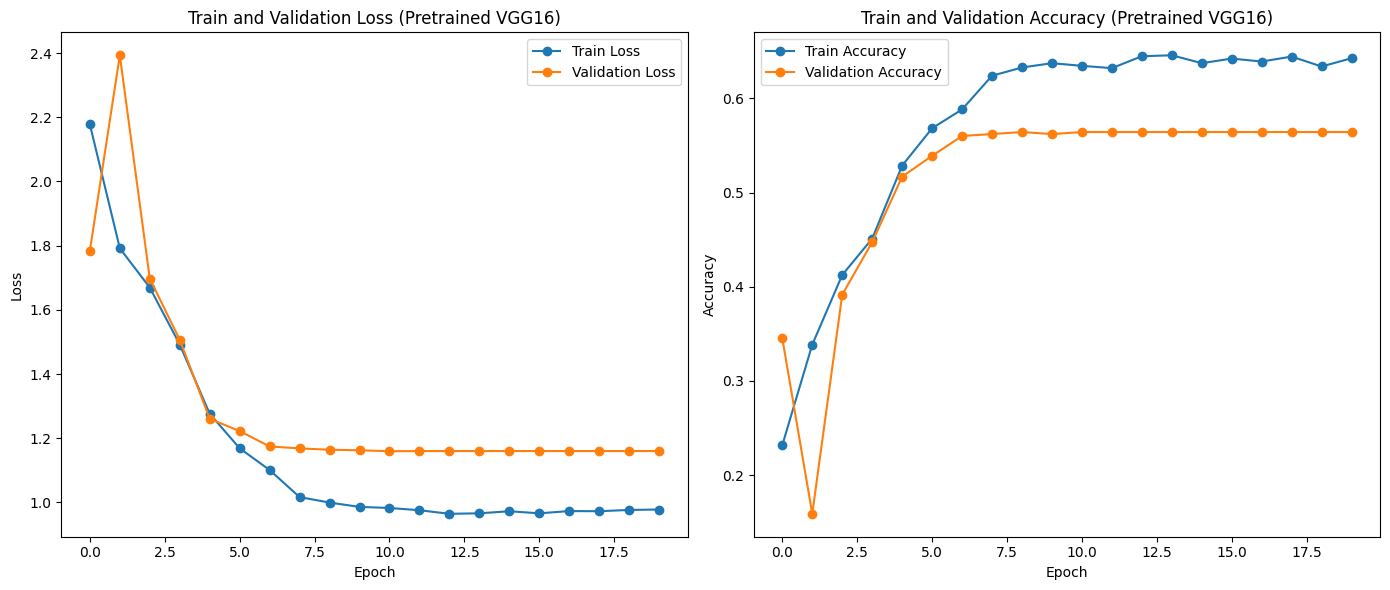

<Figure size 640x480 with 0 Axes>

In [48]:
import matplotlib.pyplot as plt

# Data from the epochs
train_loss = losses['train']
val_loss = losses['val']
train_acc = accuracies['train']
val_acc = accuracies['val']

epochs = list(range(20))

# Plot Loss
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss (Pretrained VGG16)')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy (Pretrained VGG16)')
plt.legend()

plt.tight_layout()
plt.show()

# save image as png
plt.savefig("/content/drive/MyDrive/pr_group_assignment/train_val_loss_acc_pretrained_vgg16_lr_0.001.png")


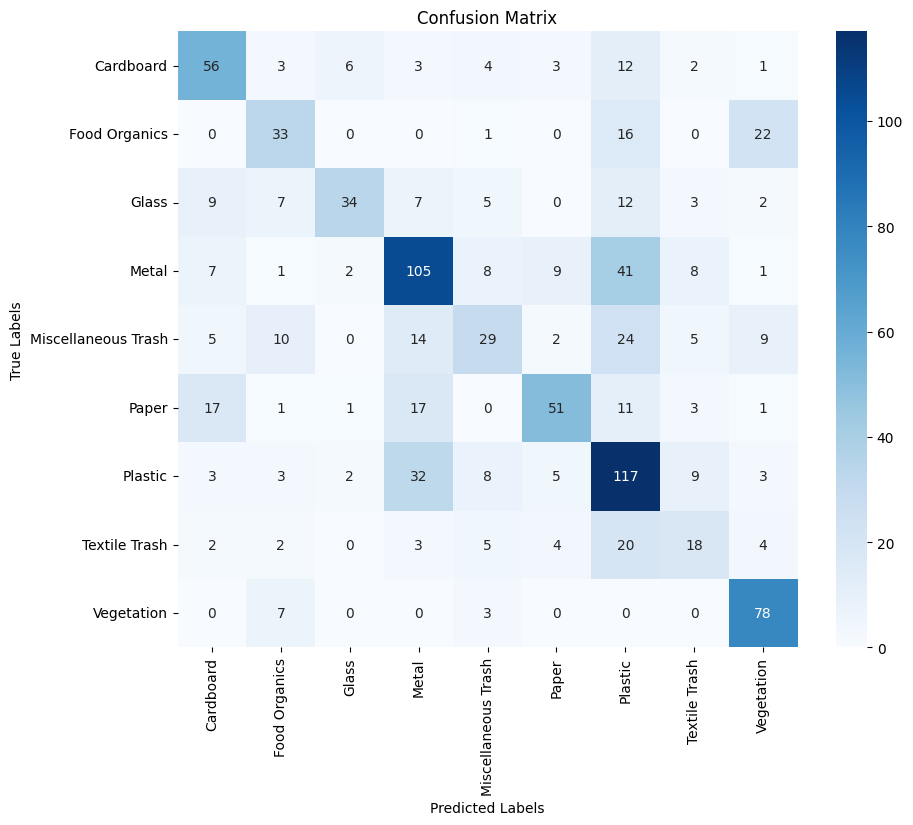

Test Accuracy: 0.5478443743427971
Precision: 0.5569847170380662
Recall: 0.5478443743427971


<Figure size 640x480 with 0 Axes>

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# prompt: evaluate the pretrained model on test dataset

# Assuming 'pretrained_trash_classifier' is your trained model and 'test_loader' is your test data loader
# Load the best model
# Replace with your model's path if needed

pretrained_trash_classifier.to(device)  # Make sure the model is on the correct device
pretrained_trash_classifier.eval()  # Set the model to evaluation mode


# Make predictions on the test set
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = pretrained_trash_classifier(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualize the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)  # Use the class names you defined earlier
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# save image
plt.savefig("/content/drive/MyDrive/pr_group_assignment/confusion_matrix_pretrained_vgg16.png")

from sklearn.metrics import accuracy_score, precision_score, recall_score

# Assuming 'all_preds' and 'all_labels' are already defined from the previous code

# Calculate the test accuracy
test_accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {test_accuracy}")

# Calculate precision
precision = precision_score(all_labels, all_preds, average="weighted")  # Use 'weighted' for multi-class problems

# Calculate recall
recall = recall_score(all_labels, all_preds, average="weighted")  # Use 'weighted' for multi-class problems

print(f"Precision: {precision}")
print(f"Recall: {recall}")